In [109]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
import os
import random
import torch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score


Define a function to set a seed for reproducibility

In [7]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ['PYTHONHASHSEED']=str(seed)

seed_everything(42)

First read in the data and split into train/test

In [10]:
os.chdir('C:\\Users\\Daniel\\Desktop\\Grad school\\UWaterloo Masters\\Winter 2024\\STAT923\\Final Project\\STAT932_Final_Project\\Images')
data = pd.read_csv('data.csv')
data.head()

,images,labels
0,20130529_01_Driv_001_f .jpg,0
1,20130529_01_Driv_002_f .jpg,0
2,20130529_01_Driv_003_f .jpg,0
3,20130529_01_Driv_004_f .jpg,0
4,20130529_01_Driv_005_f .jpg,0


In [15]:
X_train, X_test, y_train, y_test = train_test_split(data['images'], data['labels'], 
                                                    test_size = 0.2, stratify= data['labels'],
                                                    random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(484,)
(484,)
(122,)
(122,)


We can write a function to load our images and do some initial preprocessing such as reshaping and standardizing

In [47]:
def preproc_images(image_paths, label_images, target_size = (80,80)):
    images = []
    labels = []
    idx = 0
    for img_path in image_paths:
        with Image.open(img_path) as img:
            img_resized = img.resize(target_size)
            #img_gray = img_resized.convert('L')
            img_array = np.array(img_resized) / 255.0
            images.append(img_array)
            labels.append(label_images[idx])
        idx += 1
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

os.chdir('C:\\Users\\Daniel\\Desktop\\Grad school\\UWaterloo Masters\\Winter 2024\\STAT923\\Final Project\\STAT932_Final_Project\\Images\\DrivImages')
train_images, train_labels = preproc_images(list(X_train), list(y_train))
test_images, test_labels = preproc_images(list(X_test), list(y_test))

Due to a heavy class imbalance we can apply data augmentation on our train data, for the minority classes (1, 2), to increase our training size

In [57]:
pd.Series(train_labels).value_counts()

0    436
1     26
2     22
dtype: int64

In [98]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
)

labels_to_augment = [1, 2]

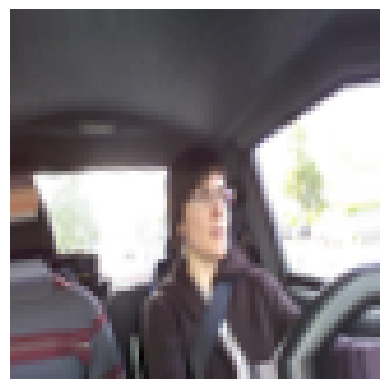

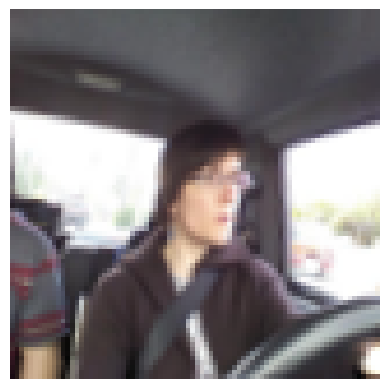

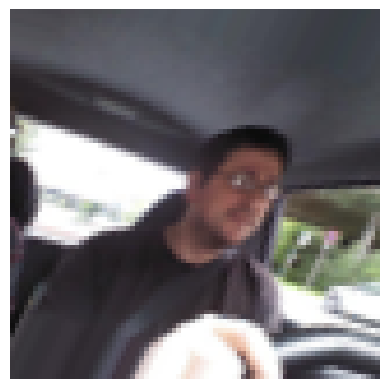

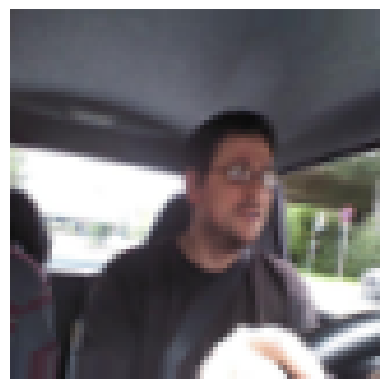

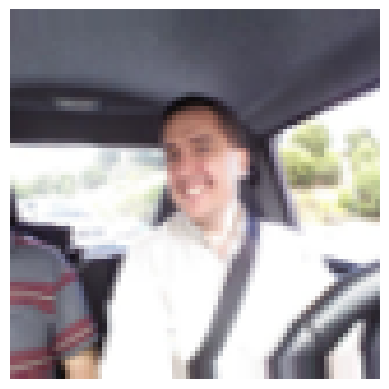

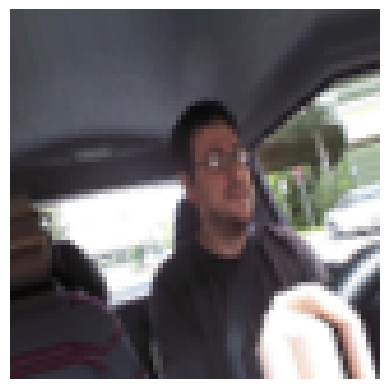

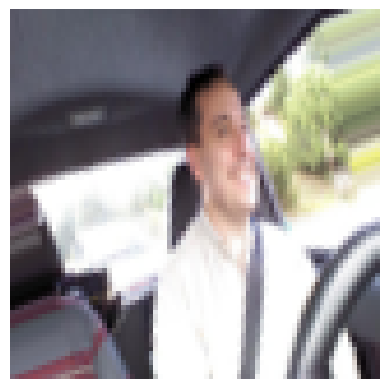

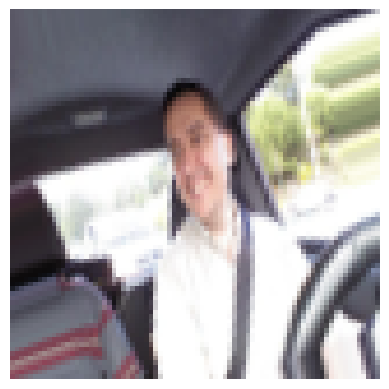

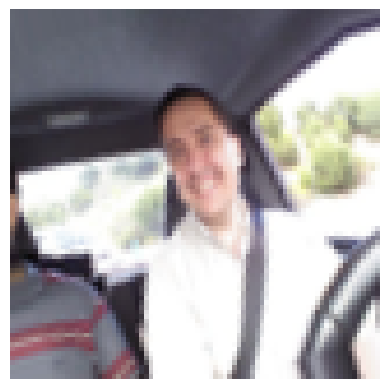

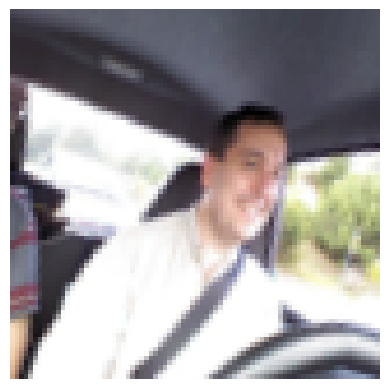

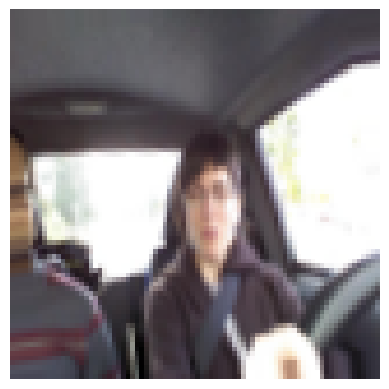

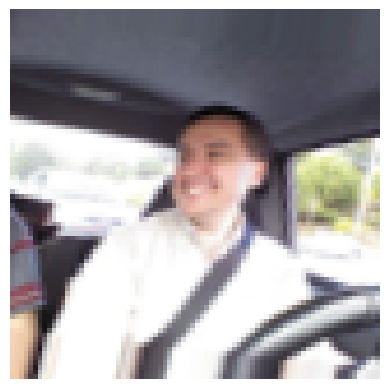

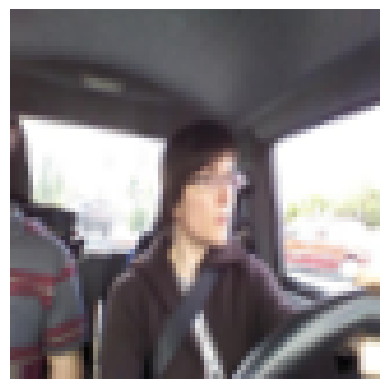

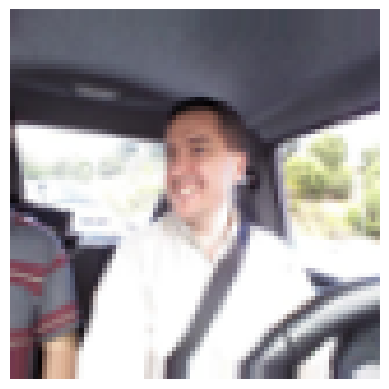

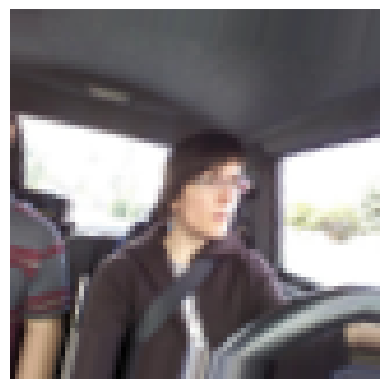

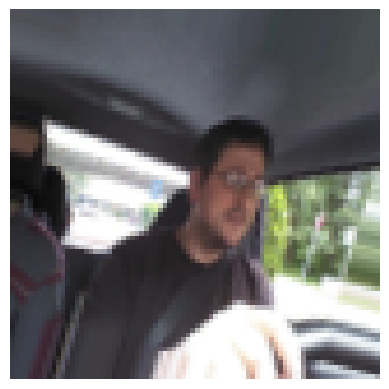

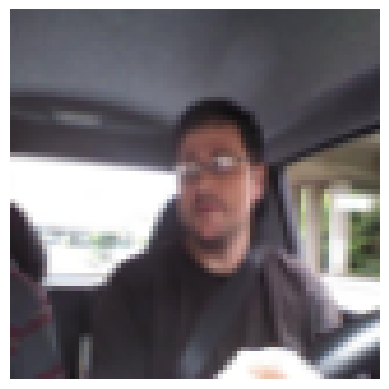

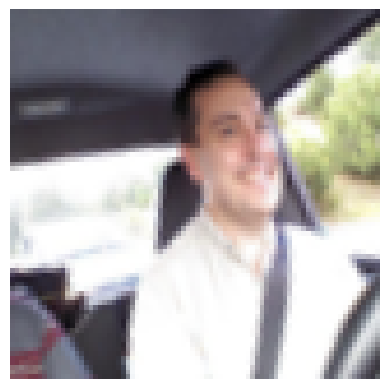

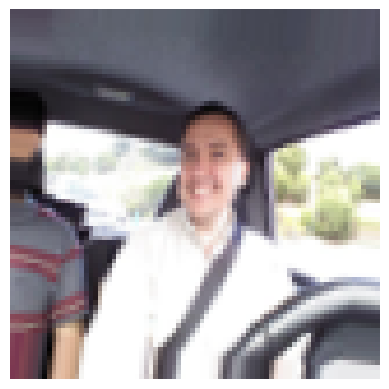

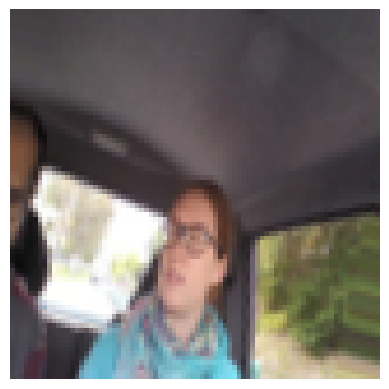

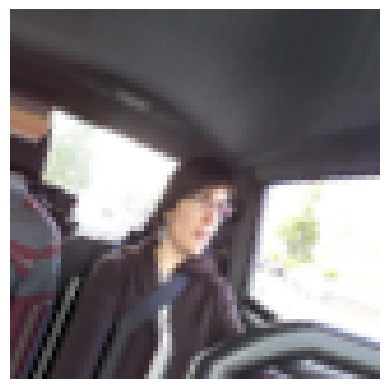

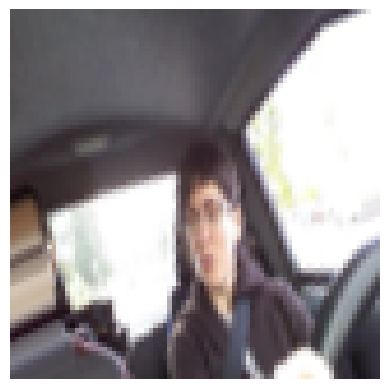

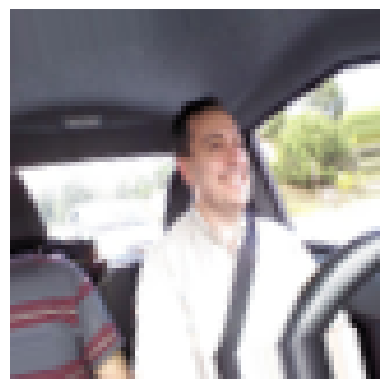

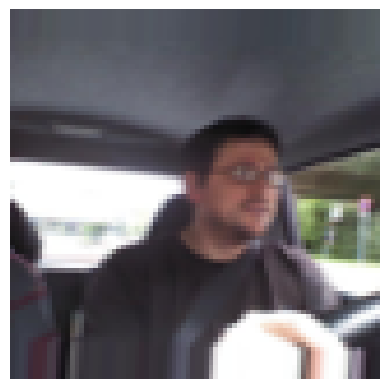

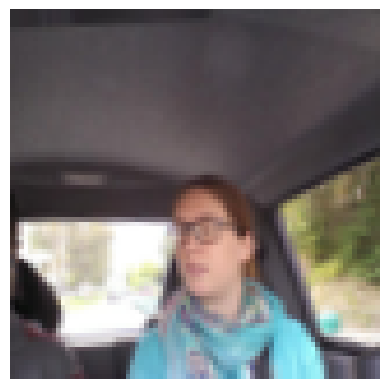

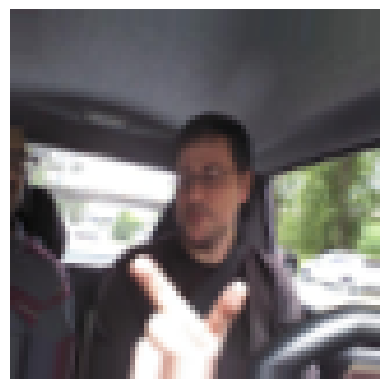

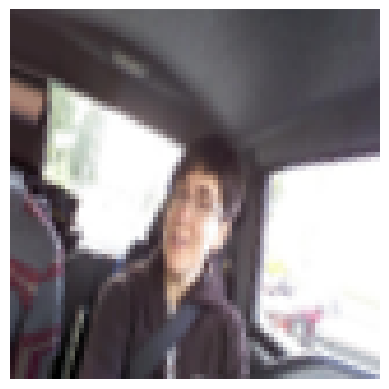

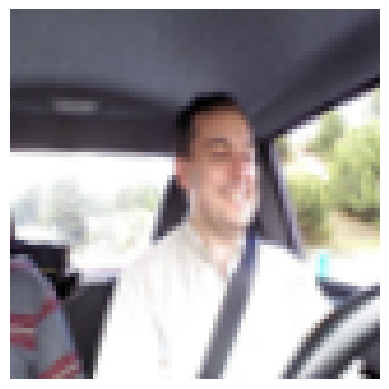

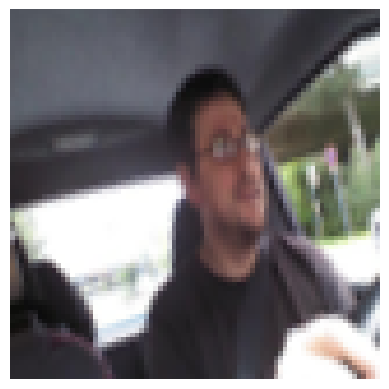

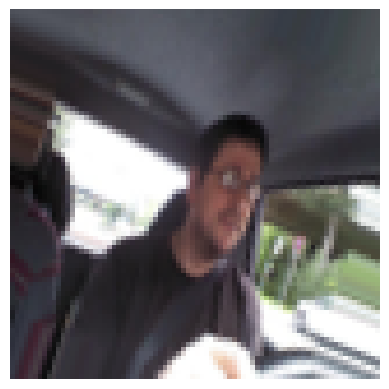

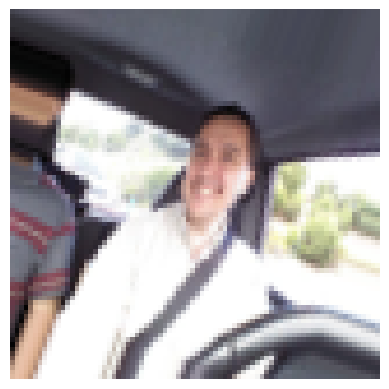

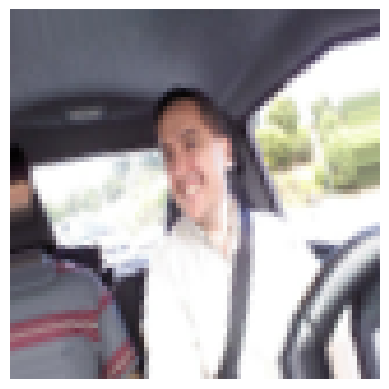

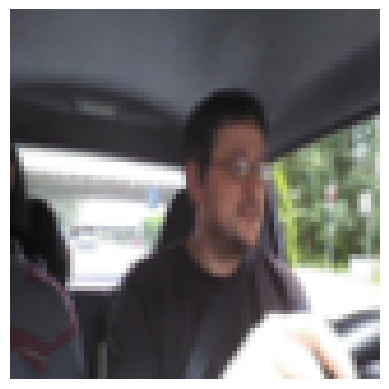

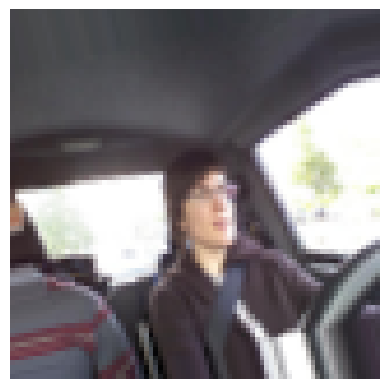

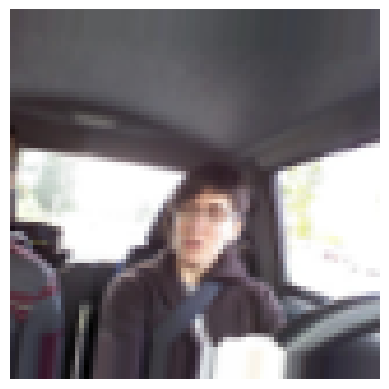

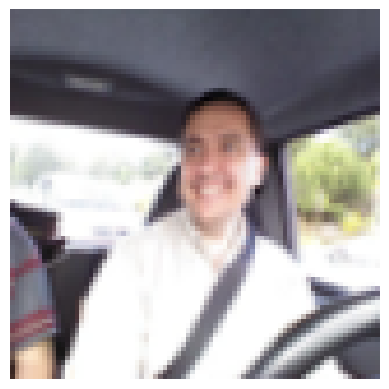

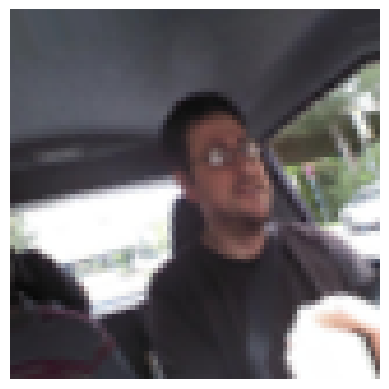

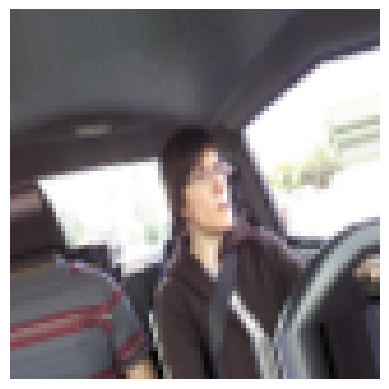

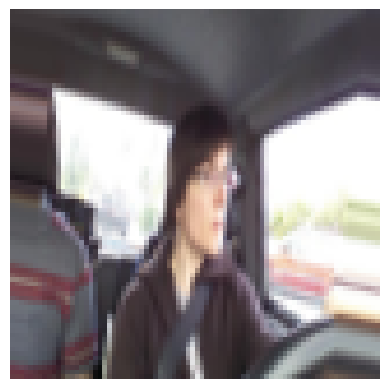

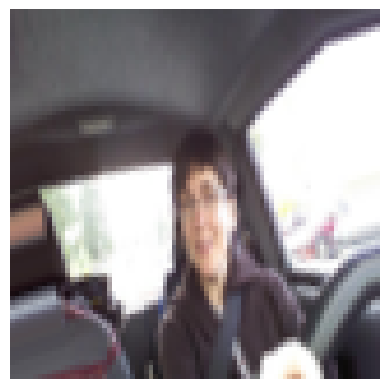

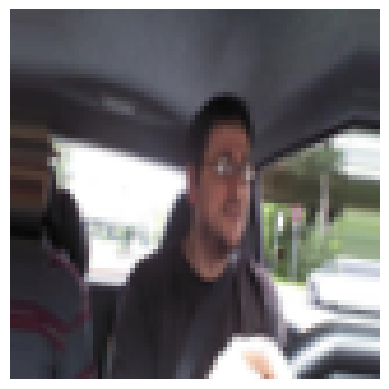

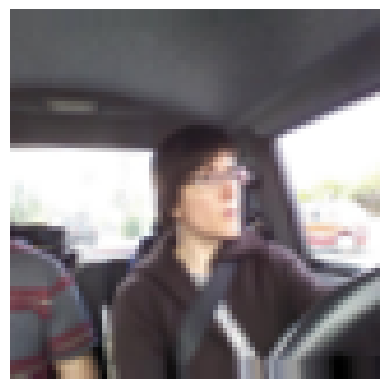

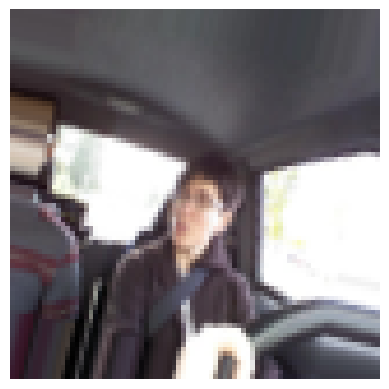

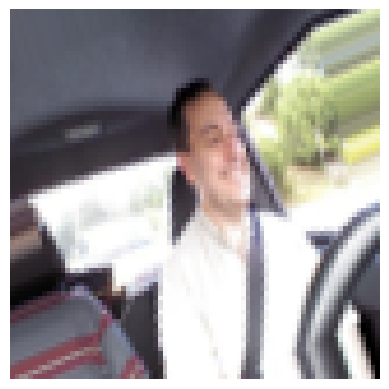

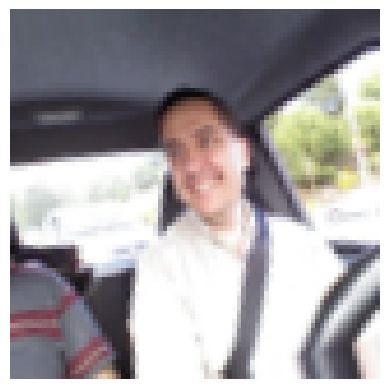

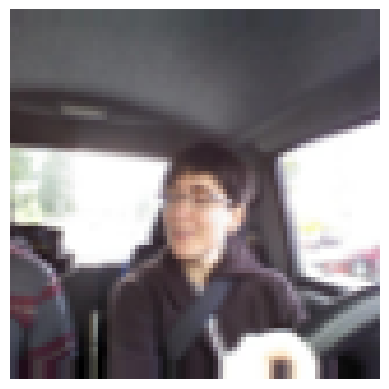

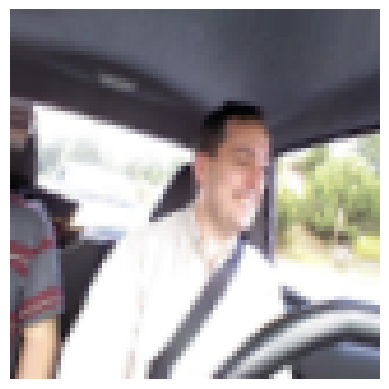

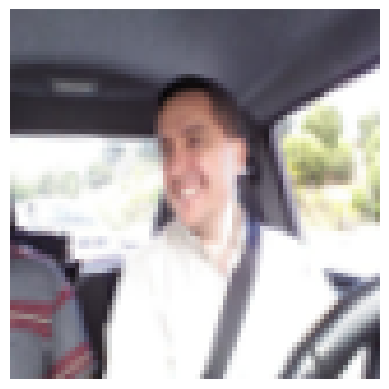

In [115]:
augmented_train_images = []
augmented_train_labels = []

augmentations_per_image = 18


for img, label in zip(train_images, train_labels):
    if label in labels_to_augment:
        img = img.reshape((1,) + img.shape)
        idx = 0
        augment = data_gen.flow(img, batch_size = 1)
        for batch in augment:
            augmented_image = batch[0]
            augmented_train_images.append(augmented_image)
            augmented_train_labels.append(label)
            idx += 1

            if idx == 5:
                plt.imshow(augmented_image, cmap='gray')
                plt.axis('off') 
                plt.show()

            if idx >= augmentations_per_image:
                break
            
    else:
        augmented_train_images.append(img)
        augmented_train_labels.append(label)


augmented_train_images = np.array(augmented_train_images)
augmented_train_labels = np.array(augmented_train_labels)

In [116]:
print(augmented_train_images.shape)
print(pd.Series(augmented_train_labels).value_counts())
print(augmented_train_labels.shape)

(1300, 80, 80, 3)
1    468
0    436
2    396
dtype: int64
(1300,)


We now have more of an even distribution of labels in our training data. We can now apply the LDA classifier

In [117]:
# First reshape the images
augmented_train_images_reshaped = augmented_train_images.reshape(augmented_train_images.shape[0], -1)
test_images_reshaped = test_images.reshape(test_images.shape[0], -1)
print(augmented_train_images_reshaped.shape)
print(test_images_reshaped.shape)

(1300, 19200)
(122, 19200)


In [118]:
lda = LDA()
lda.fit(augmented_train_images_reshaped, augmented_train_labels)

LinearDiscriminantAnalysis()

We can now perform predictions on both of our test and train sets to get accuracies

In [119]:
y_pred_train = lda.predict(augmented_train_images_reshaped)
y_pred_test = lda.predict(test_images_reshaped)

In [120]:
train_acc = accuracy_score(augmented_train_labels,y_pred_train)
test_acc = accuracy_score(test_labels,y_pred_test)

print(f"Train Accuracy: {train_acc*100:.2f}%")
print(f"Test Accuracy: {test_acc*100:.2f}%")

Train Accuracy: 100.00%
Test Accuracy: 90.98%
